## **Introduction to Image Processing**

Mojdeh Rastgoo - Desire Sidibe

## 3. Interpolation and Blending

 Importing necessary libraries/modules and functions

In [3]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image


Pretty printing has been turned ON


### 3.1  Resizing an image size using different interpolation functions

** Q.1 Resize the `lena` or `vibot` image using nearest, bilinear and bicubic function.** 

You can define your function which accept the model and resize size from the user or just run a script.

In [4]:
lena = io.imread("./images/lena-grey.bmp")
vibot = io.imread("./images/vibot-color.jpg")

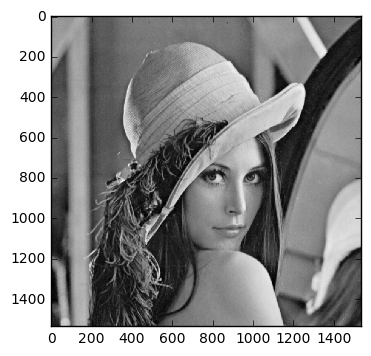

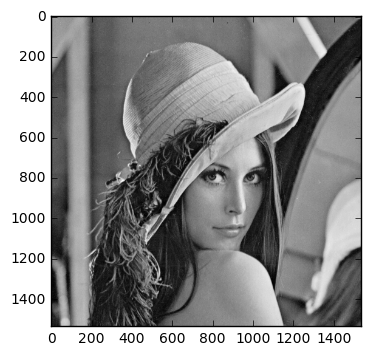

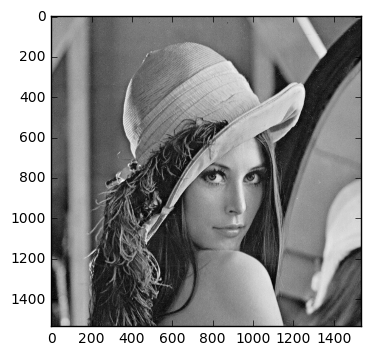

In [5]:
plt.figure()
lena_near = misc.imresize(lena, 3.0, "nearest")
plt.imshow(lena_near, cmap=plt.cm.gray)


plt.figure()
lena_bilinear = misc.imresize(lena, 3.0, "bilinear")
plt.imshow(lena_bilinear, cmap=plt.cm.gray)


plt.figure()
lena_bicubic = misc.imresize(lena, 3.0, "bicubic")
plt.imshow(lena_bicubic, cmap=plt.cm.gray)


**Q.2 Write three functions that performs `simple_blend`, `alpha_blend` and `pyramid_blend`**

** Using your functions, blend `orange` and `apple` images together.**


In [22]:
def simple_blend(im1,im2):
    if(im1.shape != im2.shape):
        raise ValueError('Images must be same size')
        return
    img1 = img_as_float(im1)
    img2 = img_as_float(im2)
    
    img_out = np.zeros(img1.shape)
    img_out[:, 0: int(img_out.shape[1]/2)] =  img1[:, 0:int(img1.shape[1]/2)]
    img_out[:, int(img_out.shape[1]/2):] =  img2[:, int(img1.shape[1]/2):]
    return img_out

In [23]:
def alpha_blend(im1,im2):
    if(im1.shape != im2.shape):
        raise ValueError('Images must be same size')
        return
    img1 = img_as_float(im1)
    img2 = img_as_float(im2)

    alpha_window = 13
    alpha_image = np.zeros((img1.shape[0],alpha_window*2,3))
    alpha_image[:,:,0] = alpha_image[:,:,1] = alpha_image[:,:,2] = \
    np.tile(np.linspace(0, 1, alpha_window*2, endpoint=True), (img1.shape[0],1))
        
    #Initialize image with simple blending
    img_out = np.zeros(img1.shape)
    img_out[:, 0: int(img_out.shape[1]/2)] =  img1[:, 0:int(img1.shape[1]/2)]
    img_out[:, int(img_out.shape[1]/2):] =  img2[:, int(img2.shape[1]/2):]
        
    #Fill masked region 
    img_out[:, int(img_out.shape[1]/2)-alpha_window:int(img_out.shape[1]/2)+alpha_window] = \
    img1[:, int(img_out.shape[1]/2)-alpha_window:int(img_out.shape[1]/2)+alpha_window]*(1-alpha_image) + \
    img2[:, int(img_out.shape[1]/2)-alpha_window:int(img_out.shape[1]/2)+alpha_window]*alpha_image 
        
    return img_out

In [19]:
def pyramid_blend(im1,im2,mask=None):
    if(im1.shape != im2.shape):
        raise ValueError('Images must be same size')
        return
    img1 = img_as_float(im1)
    img2 = img_as_float(im2)
    
    if(mask == None):
        mask_mono = np.ones((img1.shape[0], img2.shape[1]))
        mask_mono[:, int(img1.shape[1]/2):] = mask_mono[:, int(img1.shape[1]/2):] - 1.0

        mask = np.zeros((mask_mono.shape[0], mask_mono.shape[1], 3))
        mask[:,:,0] = mask[:,:,1] = mask[:,:,2] = mask_mono

    #Create Gaussian pyramid 
    num_layers = 5
    pyr_gauss_mask = [a for a in transform.pyramid_gaussian(mask, max_layer=num_layers)]
    pyr_gauss_img1 = [b for b in transform.pyramid_gaussian(img1, max_layer=num_layers)]
    pyr_gauss_img2 = [c for c in transform.pyramid_gaussian(img2, max_layer=num_layers)]

    #Create laplacian pyramid 
    pyr_lap_img1 = list(pyr_gauss_img1)
    pyr_lap_img2 = list(pyr_gauss_img2)

    for i in range(num_layers-1):
        pyr_lap_img1[i] -= transform.resize(transform.rescale(pyr_lap_img1[i+1], 2), pyr_lap_img1[i].shape)
        pyr_lap_img2[i] -= transform.resize(transform.rescale(pyr_lap_img2[i+1], 2), pyr_lap_img2[i].shape)

    #Create laplacian pyramid of result by using mask multpilication pyramid 
    pyr_lap_output = list(pyr_lap_img1)
    for i in range(num_layers):
        pyr_lap_output[i] =  pyr_lap_img1[i] * pyr_gauss_mask[i] + pyr_lap_img2[i] * (1 - pyr_gauss_mask[i])

    #Recompose final image using laplacian pyramid levels
    img_out = pyr_lap_output[num_layers-1]
    for i in range(num_layers-2,-1,-1):    
        img_out = transform.resize(transform.rescale(img_out, 2),pyr_lap_output[i].shape) + pyr_lap_output[i]

    return img_out

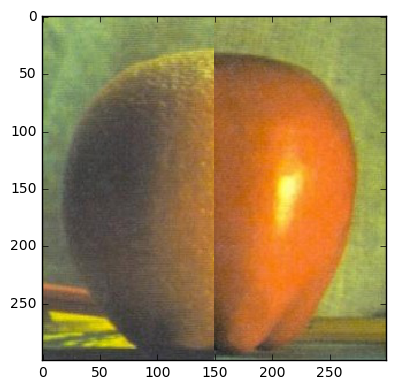

In [16]:
### SIMPLE ###

img_orange = io.imread("./images/orange.jpeg")
img_apple =  io.imread("./images/apple.jpeg")

im_blended_simple = simple_blend(img_orange, img_apple)
io.imshow(im_blended_simple)


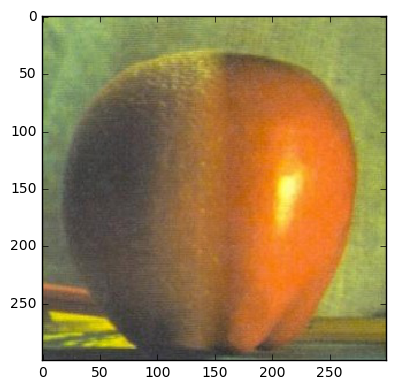

In [24]:
### ALPHA ###

img_orange = io.imread("./images/orange.jpeg")
img_apple =  io.imread("./images/apple.jpeg")

im_blended_alpha = alpha_blend(img_orange, img_apple)
io.imshow(im_blended_alpha)


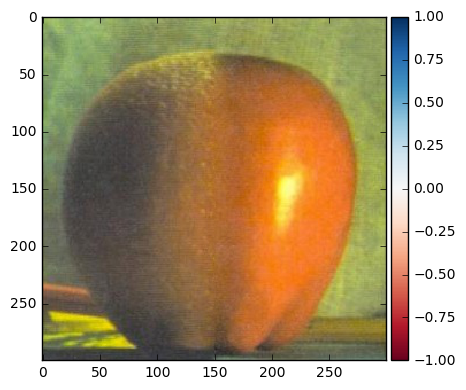

In [20]:
### PYRAMID ###

img_orange = io.imread("./images/orange.jpeg")
img_apple =  io.imread("./images/apple.jpeg")

im_blended_pyramid = pyramid_blend(img_orange, img_apple)
io.imshow(im_blended_pyramid)
